# Creating Learning Model for Rust Detection on any Steels

# 1. Preparation

In [ ]:
pip install pillow

Importing all necessary library

In [ ]:
import os
import tensorflow as tf
import numpy as np
import pydot
import matplotlib.pyplot as plt
from keras.applications import Xception
from keras import Model
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import random
import shutil
from shutil import copyfile

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defining paths

In [ ]:
source_dir = "/content/drive/MyDrive/Machine Learning"
norust = "/content/drive/MyDrive/Machine Learning/norust"
rust = "/content/drive/MyDrive/Machine Learning/rusts"

Renaming datasets / files

In [ ]:
# Rename file
norust_chdir = os.chdir(norust)
len(os.listdir(norust_chdir))

i = 0
for file in os.listdir(norust_chdir):
  new_file_name = "no-rust{}.jpg".format(i)
  os.rename(file, new_file_name)
  i = i + 1

In [ ]:
!pwd

/content/drive/MyDrive/Machine Learning/norust


In [ ]:
rust_chdir = os.chdir(rust)
len(os.listdir(rust_chdir))

n = 0
for file in os.listdir(rust_chdir):
  new_file_name = "rust{}.jpg".format(n)
  os.rename(file, new_file_name)
  n = n + 1

In [ ]:
!pwd

/content/drive/MyDrive/Machine Learning/rusts


In [ ]:
print(len(os.listdir(norust)))
print(len(os.listdir(rust)))

466
466


In [ ]:
# Re-check order
for files in os.listdir(norust_chdir):
    print(files)

for file in os.listdir(rust_chdir):
    print(file)

Creating directory for training set and testing set

In [ ]:
# Create Directory
os.makedirs(os.path.join(source_dir, 'training'))
os.makedirs(os.path.join(f'{source_dir}/training', 'rust'))
os.makedirs(os.path.join(f'{source_dir}/training', 'norust'))
os.makedirs(os.path.join(source_dir, 'testing'))
os.makedirs(os.path.join(f'{source_dir}/testing', 'rust'))
os.makedirs(os.path.join(f'{source_dir}/testing', 'norust'))

Defining training and testing directory path

In [ ]:
TRAINING_DIR = "/content/drive/MyDrive/Machine Learning/training"
VALIDATION_DIR = "/content/drive/MyDrive/Machine Learning/testing"

TRAINING_N_DIR = "/content/drive/MyDrive/Machine Learning/training/norust/"
TRAINING_R_DIR = "/content/drive/MyDrive/Machine Learning/training/rust/"
TESTING_N_DIR = "/content/drive/MyDrive/Machine Learning/testing/norust/"
TESTING_R_DIR = "/content/drive/MyDrive/Machine Learning/testing/rust/"

# 2. Splitting datasets into Training and Validation

In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    files = os.listdir(SOURCE_DIR)
    random.shuffle(files)

    split = int(len(files) * SPLIT_SIZE)

    for i, filename in enumerate(files):
        if os.path.getsize(os.path.join(SOURCE_DIR, filename)) == 0:
            print(f'{filename} is zero length, so ignoring.')
            continue

        if i < split:
            destination = os.path.join(TRAINING_DIR, filename)
        else:
            destination = os.path.join(VALIDATION_DIR, filename)

        source = os.path.join(SOURCE_DIR, filename)
        copyfile(source, destination)

In [ ]:
split_size= 0.8
split_data(norust, TRAINING_N_DIR, TESTING_N_DIR, split_size)
split_data(rust, TRAINING_R_DIR, TESTING_R_DIR, split_size)

print(f"\n\nOriginal norust's directory has {len(os.listdir(norust))} images")
print(f"Original rust's directory has {len(os.listdir(rust))} images\n")
print(f"There are {len(os.listdir(TRAINING_N_DIR))} images of no-rust for training")
print(f"There are {len(os.listdir(TRAINING_R_DIR))} images of rust for training")
print(f"There are {len(os.listdir(TESTING_N_DIR))} images of no-rust for validation")
print(f"There are {len(os.listdir(TESTING_R_DIR))} images of rust for validation")



Original norust's directory has 466 images
Original rust's directory has 466 images

There are 372 images of no-rust for training
There are 372 images of rust for training
There are 94 images of no-rust for validation
There are 94 images of rust for validation


In [ ]:
len(os.listdir(TRAINING_DIR))
len(os.listdir(VALIDATION_DIR))

2

this code is for deleting datasets that has been distributed into training and testing folder

In [ ]:
# USE THIS CODE ONLY FOR CLEAN UP
if len(os.listdir(TRAINING_N_DIR)) > 0:
  for file in os.scandir(TRAINING_N_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_R_DIR)) > 0:
  for file in os.scandir(TRAINING_R_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_N_DIR)) > 0:
  for file in os.scandir(TESTING_N_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_R_DIR)) > 0:
  for file in os.scandir(TESTING_R_DIR):
    os.remove(file.path)

print(f"There are {len(os.listdir(TRAINING_N_DIR))} images of no-rust for training")
print(f"There are {len(os.listdir(TRAINING_R_DIR))} images of rust for training")
print(f"There are {len(os.listdir(TESTING_N_DIR))} images of no-rust for validation")
print(f"There are {len(os.listdir(TESTING_R_DIR))} images of rust for validation")

There are 0 images of no-rust for training
There are 0 images of rust for training
There are 0 images of no-rust for validation
There are 0 images of rust for validation


Make Labels

In [ ]:
class_labels = ['No-Rust', 'Rusty']
os.chdir("/content/drive/MyDrive/Machine Learning/model")
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_labels))

# 3. Augmenting Datasets

In [ ]:
def train_val_gen(TRAINING_DIR,VALIDATION_DIR):
  train_datagen = ImageDataGenerator(
      rescale= 1.0/255.0,
      rotation_range = 40,
      zoom_range=0.2,
      shear_range=0.2,
      width_shift_range=0.4,
      height_shift_range=0.4,
      fill_mode="nearest",
      horizontal_flip=True,
      vertical_flip=True
  )
  validation_datagen = ImageDataGenerator(
      rescale=1.0/255.0
  )

  train_gen = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,
      batch_size=32,
      class_mode='categorical',
      target_size=(224,224)
  )
  validation_gen = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,
      batch_size=32,
      class_mode='categorical',
      target_size=(224,224)
  )

  return train_gen,validation_gen

In [ ]:
train_gen, validation_gen = train_val_gen(TRAINING_DIR,VALIDATION_DIR)

val_labels = validation_gen.class_indices
print(val_labels)

Found 744 images belonging to 2 classes.
Found 188 images belonging to 2 classes.
{'norust': 0, 'rust': 1}


# 4. Creating Model Architecture

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
 6 (GlobalAveragePooling2D)                                      
                                                                 
 dense_144 (Dense)           (None, 256)               524544    
                                                                 
 batch_normalization_147 (B  (None, 256)               1024      
 atchNormalization)                                              
                                                                 
 dense_145 (Dense)           (None, 128)               32896     
                                                                 
 batch_normalization_148 (B  (None, 128)             

In [ ]:
class modelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.88 and logs.get('val_accuracy') > 0.88:
      self.model.stop_training = True

In [ ]:
# Compile Model
callback = modelCallback()

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.categorical_crossentropy
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(train_gen, epochs=20, validation_data=validation_gen, callbacks=callback)

Epoch 1/20
24/24 [==============================] - 34s 1s/step - loss: 0.8174 - accuracy: 0.6277 - val_loss: 0.6376 - val_accuracy: 0.6011
Epoch 2/20
24/24 [==============================] - 27s 1s/step - loss: 0.5672 - accuracy: 0.7473 - val_loss: 0.5759 - val_accuracy: 0.7287
Epoch 3/20
24/24 [==============================] - 27s 1s/step - loss: 0.4509 - accuracy: 0.7984 - val_loss: 0.5246 - val_accuracy: 0.8085
Epoch 4/20
24/24 [==============================] - 26s 1s/step - loss: 0.4121 - accuracy: 0.8333 - val_loss: 0.4791 - val_accuracy: 0.8723
Epoch 5/20
24/24 [==============================] - 26s 1s/step - loss: 0.3676 - accuracy: 0.8347 - val_loss: 0.4243 - val_accuracy: 0.8777
Epoch 6/20
24/24 [==============================] - 24s 1s/step - loss: 0.3186 - accuracy: 0.8696 - val_loss: 0.3758 - val_accuracy: 0.8883
Epoch 7/20
24/24 [==============================] - 26s 1s/step - loss: 0.3351 - accuracy: 0.8710 - val_loss: 0.3407 - val_accuracy: 0.8830
Epoch 8/20
24/24 [==

Post-Training Validation

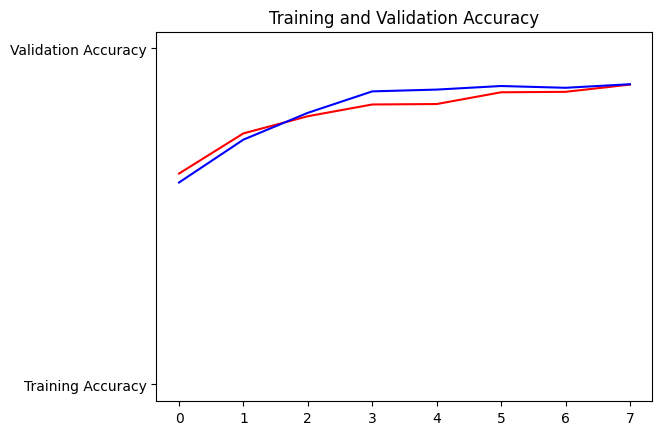

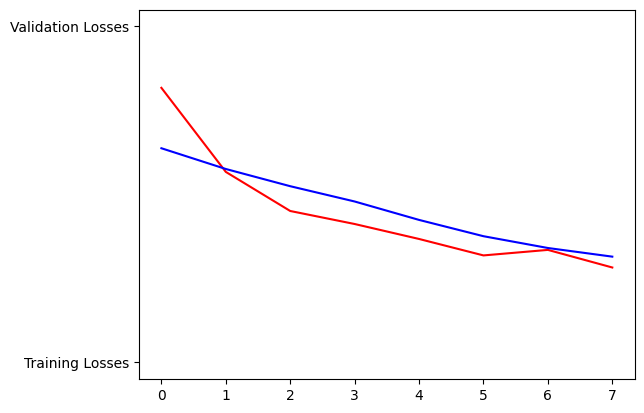

In [ ]:
acc = history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epoch=range(len(acc))

plt.plot(epoch, acc, 'r', "Training Accuracy")
plt.plot(epoch, val_acc, 'b', "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.show()
print("")

plt.plot(epoch, loss, 'r', "Training Losses")
plt.plot(epoch, val_loss, 'b', "Validation Losses")
plt.show()

Fine-Tuning

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_16[0][0]']            
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [ ]:
print('Number of layers in the Xception Model : ', len(base_model.layers))

pick_layer = base_model.get_layer("add_178")
pick_layer_index = base_model.layers.index(pick_layer)
# Here I am training the layers from add_11 layer onwards.
for layer in base_model.layers[pick_layer_index:]:
    layer.trainable=True

Number of layers in the Xception Model :  132


In [ ]:
model_tuned = tf.keras.Sequential([
   base_model,
   tf.keras.layers.GlobalAveragePooling2D(),
   tf.keras.layers.Dense(2, activation='softmax')
])

model_tuned.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = loss,
    metrics=['accuracy']
)

In [ ]:
history_tuned = model.fit(train_gen, epochs=10, validation_data=validation_gen)

Epoch 1/10
24/24 [==============================] - 27s 1s/step - loss: 0.2672 - accuracy: 0.8911 - val_loss: 0.2863 - val_accuracy: 0.8936
Epoch 2/10
24/24 [==============================] - 26s 1s/step - loss: 0.2482 - accuracy: 0.8965 - val_loss: 0.2652 - val_accuracy: 0.8989
Epoch 3/10
24/24 [==============================] - 27s 1s/step - loss: 0.2911 - accuracy: 0.8831 - val_loss: 0.2402 - val_accuracy: 0.9096
Epoch 4/10
24/24 [==============================] - 26s 1s/step - loss: 0.2317 - accuracy: 0.9126 - val_loss: 0.2187 - val_accuracy: 0.9202
Epoch 5/10
24/24 [==============================] - 27s 1s/step - loss: 0.2122 - accuracy: 0.9086 - val_loss: 0.2185 - val_accuracy: 0.9149
Epoch 6/10
24/24 [==============================] - 24s 1s/step - loss: 0.2180 - accuracy: 0.9167 - val_loss: 0.2026 - val_accuracy: 0.9362
Epoch 7/10
24/24 [==============================] - 26s 1s/step - loss: 0.2117 - accuracy: 0.9153 - val_loss: 0.1918 - val_accuracy: 0.9468
Epoch 8/10
24/24 [==

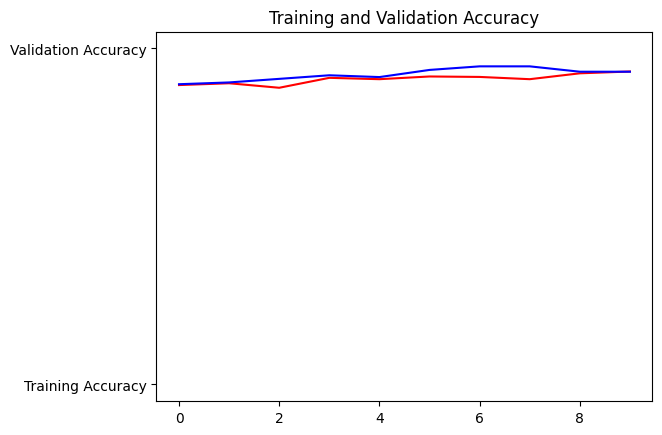

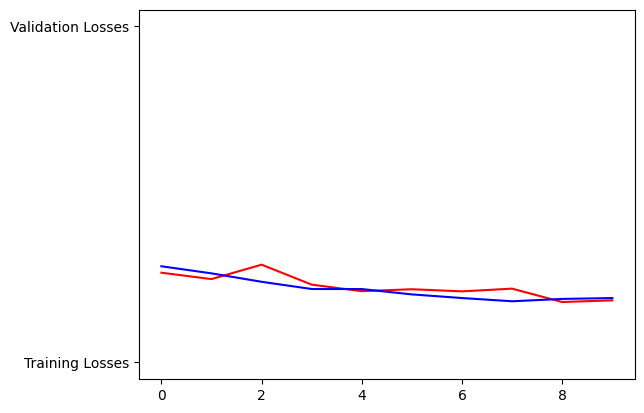

In [ ]:
acc = history_tuned.history['accuracy']
val_acc=history_tuned.history['val_accuracy']
loss=history_tuned.history['loss']
val_loss=history_tuned.history['val_loss']
epoch=range(len(acc))

plt.plot(epoch, acc, 'r', "Training Accuracy")
plt.plot(epoch, val_acc, 'b', "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.show()
print("")

plt.plot(epoch, loss, 'r', "Training Losses")
plt.plot(epoch, val_loss, 'b', "Validation Losses")
plt.show()

Evaluating Model

In [ ]:
validation_results = model.evaluate(validation_gen)

print("Validation Loss: {:.1f}%".format(validation_results[0] * 100))
print("Validation Accuracy: {:.1f}%".format(validation_results[1] * 100))

predictions = model.predict(validation_gen)
# Check the shape of the predictions
print("Shape of predictions:", predictions.shape)

6/6 [==============================] - 3s 538ms/step - loss: 0.1917 - accuracy: 0.9309
Validation Loss: 19.2%
Validation Accuracy: 93.1%
6/6 [==============================] - 4s 534ms/step
Shape of predictions: (188, 2)


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6/6 [==============================] - 4s 700ms/step


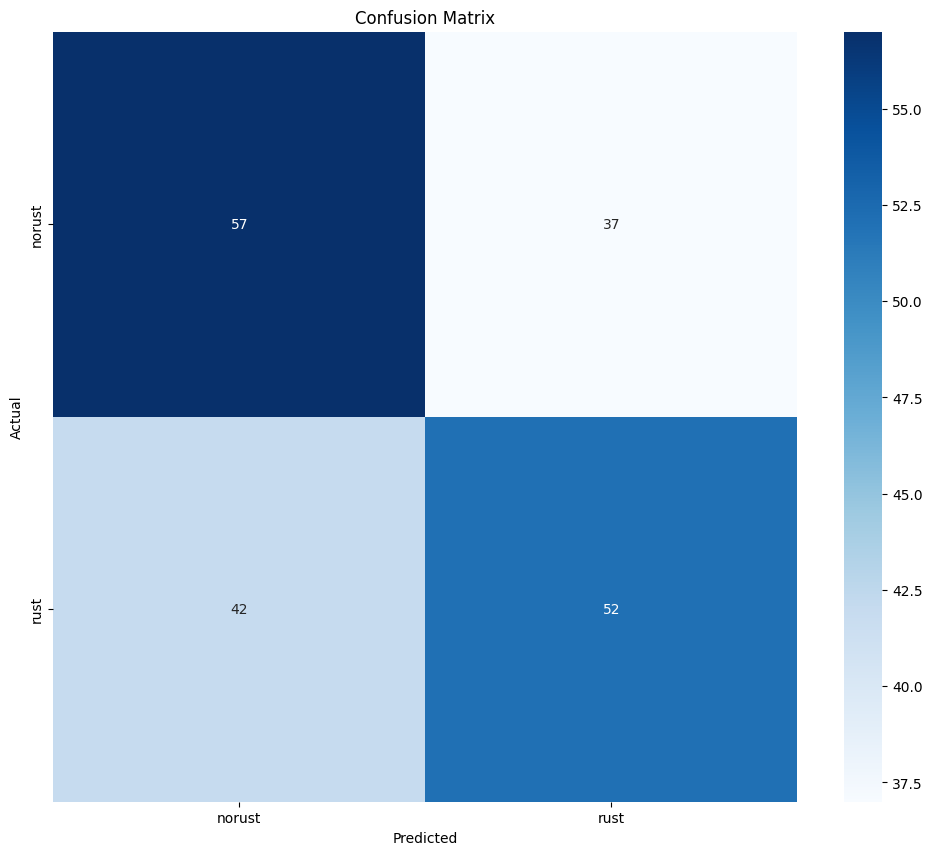

              precision    recall  f1-score   support

      norust       0.58      0.61      0.59        94
        rust       0.58      0.55      0.57        94

    accuracy                           0.58       188
   macro avg       0.58      0.58      0.58       188
weighted avg       0.58      0.58      0.58       188



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get the true labels and predicted labels for the test data
true_labels = validation_gen.classes
predicted_labels = np.argmax(model.predict(validation_gen), axis=1)

# Create a confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=validation_gen.class_indices, yticklabels=validation_gen.class_indices)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Generate and print the classification report
class_names = list(validation_gen.class_indices.keys())
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

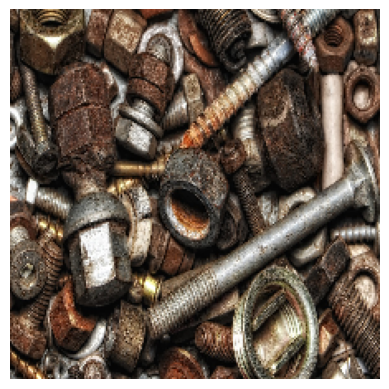

1/1 [==============================] - 0s 30ms/step
True label: rust
Predicted label: rust


In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in validation_gen.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(validation_gen)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

# 5. Saving Model

saving model into .pb and .h5

In [ ]:
# Save Model
os.chdir("/content/drive/MyDrive/Machine Learning/model")
model_dir = '/content/drive/MyDrive/Machine Learning/model/'
tf.saved_model.save(model, model_dir)
model.save("Xception_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


converting .pb into .tflite

In [ ]:
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir=model_dir)
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('./Xception_model.tflite')
tflite_model_file.write_bytes(tflite_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
q_tflite_model = converter.convert()
q_tflite_model_file = pathlib.Path('./quantized_Xception_model.tflite')
q_tflite_model_file.write_bytes(q_tflite_model)

22099208